In [18]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import seaborn as sns
import pymc3 as pm
from roverdata.db import DataWarehouse
from taxes_increase import utils

## Get Early Data

In [13]:
data = pd.read_csv('../early_data.csv')

In [52]:
y1 = data.sample(frac=1/3).early_gmv.values
y2 = data.sample(frac=1/3).early_gmv.values

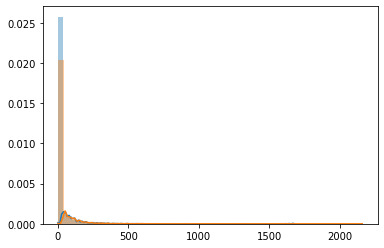

In [53]:
sns.distplot(y1)
sns.distplot(y2)

In [116]:
def setup_priors(data):
    ''' setup priors. takes in combined populations as input'''
    priors = dict()

    # Setup our priors
    lower = np.var(data)/1000.0
    upper = np.var(data)*1000

    v = pm.Exponential("nu", beta=1.0/29) + 1
    tau = 1.0/np.var(data)/1000.0
    mu1 = pm.Normal('mu1', mu=np.mean(data), tau=tau)
    var1 = pm.Uniform('var1', lower=lower, upper=upper)

    mu2 = pm.Normal('mu2', mu=np.mean(data), tau=tau)
    var2 = pm.Uniform('var2', lower=lower, upper=upper)

    priors['mu1'] = mu1
    priors['var1'] = var1
    priors['mu2'] = mu2
    priors['var2'] = var2
    priors['v'] = v
    
    return priors

In [117]:
def generate_models(values, values2, priors):
    '''generate models based on priors and given samples'''
    v = priors['v']
    mu1 = priors['mu1']
    var1 = priors['var1']
    lam1 = 1.0/var1

    mu2 = priors['mu2']
    var2 = priors['var2']
    lam2 = 1.0/var2

    # Include our observed data into the model
    t1 = pm.NoncentralT("t1", mu=mu1, lam=lam1, nu=v, value=values, observed=True)
    t2 = pm.NoncentralT("t2", mu=mu2, lam=lam2, nu=v, value=values2, observed=True)
    # Push our priors into a model
    model = pm.Model([t1, mu1, var1, t2, mu2, var2, v])
    
    return model

In [62]:
pooled = data.early_gmv.values

In [119]:
with pm.Model() as model:
    tau = 1.0/np.var(pooled)/1000.0
    group1_mean = pm.Normal('group1_mean', mu=pooled.mean(), sd=pooled.std()*2)
    group2_mean = pm.Normal('group2_mean', mu=pooled.mean(), sd=pooled.std()*2)

In [120]:
std_low = pooled.std()/1000
std_high = pooled.std()*1000

with model:
    group1_std = pm.Uniform('group1_std', lower=std_low, upper=std_high)
    group2_std = pm.Uniform('group2_std', lower=std_low, upper=std_high)

In [121]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

In [123]:
with model:
    λ1 = group1_std**-2
    λ1 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [71]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

In [72]:
with model:
    prior = pm.sample_prior_predictive(10000)
    posterior = pm.sample(2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 4 chains: 100%|██████████| 10000/10000 [4:24:07<00:00,  1.58s/draws]      
There were 1247 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0649491560169248, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9626251233464548, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth

In [94]:
posterior.varnames

['group1_mean',
 'group2_mean',
 'group1_std_interval__',
 'group2_std_interval__',
 'ν_minus_one_log__',
 'group1_std',
 'group2_std',
 'ν_minus_one',
 'difference of means',
 'difference of stds',
 'effect size']

In [113]:
diffs = posterior['difference of means']
diffs

array([-17.07416698, -17.07416698, -17.07416698, ..., -18.19933345,
       -18.19933345, -18.19933345])

In [103]:
import seaborn as sns

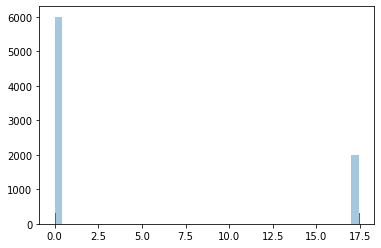

In [114]:
sns.distplot(posterior['group1_mean'], kde=False, rug=True)

## Get Sample Size Data

In [3]:
samples = pd.read_csv('../retrans.csv')
samples_new = samples.loc[samples['new_repeat']=='new'][['service','num_owners']].groupby(['service']).sum()
samples_new_account = samples.loc[samples['new_account']=='new'][['service','num_owners']].set_index('service')

In [4]:
def project_30_day_samples(df, samples_col):
    """from df with column `service` and inputted samples column (containing 30 day samples)
    , project out 45 and 60 days"""
    df = df[samples_col].reset_index().rename(columns={samples_col:'30_day'})
    df['45_day'] = (df['30_day']*1.5).astype(int)
    df['60_day'] = (df['30_day']*2).astype(int)
    return df.set_index('service')


expected_xx_day_samples_new = project_30_day_samples(df = samples_new, samples_col = 'num_owners')
expected_xx_day_samples_new_account = project_30_day_samples(df = samples_new_account, samples_col = 'num_owners')

## Estimate Distribution of Sample Statistic

#### Estimate mean of means and standard error of means of sample statistic through simulation
http://blog.analytics-toolkit.com/2017/statistical-significance-non-binomial-metrics-revenue-time-site-pages-session-aov-rpu/

In [5]:
def sample_data(df, metric, samples, simulations):
    """
    given a dataframe `df` with a metric of interst column `metric`,
    select `samples` number of samples,
    repeat for `simulations` number of simulations
    
    Returns:
        meanOfMeans (float)
        seOfMeans (float)
    """
    metric_series = df[metric]
    means = np.array([metric_series.sample(n=samples, replace=True).mean() for i in range(simulations)])
    return means.mean(), means.std()

In [6]:
def run_sample_data(df, expected_xx_day_samples):
    """loop through the services, metrics, and sample sizes and estimate mean of means and std of means"""
    dist_stats_dict = {}
    
    for service in df.service.unique():
        df_service = df.loc[df['service'] == service]
        samples = expected_xx_day_samples.loc[service].to_dict()
        for days, samples in samples.items():
            for metric in ['gmv', 'nrt', 'stays']:
                mom, seom = sample_data(df_service, metric, samples, 1000)
                dist_stats_dict[(service, metric, days)] = (samples, mom, seom)  
                
    return pd.DataFrame.from_dict(dist_stats_dict, orient='index', columns=['samples','meanOfMeans','SEOfMeans'])

In [7]:
dist_stats_new = run_sample_data(
    df=new, 
    expected_xx_day_samples = expected_xx_day_samples_new
)
dist_stats_new_account = run_sample_data(
    df=new_account, 
    expected_xx_day_samples = expected_xx_day_samples_new_account
)

## Calculate minimum effect size for 95% power at 95% significance

In [8]:
from statsmodels.stats.power import tt_ind_solve_power

In [9]:
def dict_to_df(d, col_name):
    """convert dictionary with key = (service, metric, sample_days) to a pandas dataframe 
    with columns = col_name"""
    df = pd.DataFrame.from_dict(d, orient='index').rename(columns={0:col_name})
    midx = pd.MultiIndex.from_tuples(df.index.values.tolist(), names =('service', 'metric', 'samples')) 
    df = df.set_index(midx)
    df = df.pivot_table(index = ['service','samples'],  columns = ['metric'], values = col_name)
    return df

In [45]:
def calculate_mde(dist_stats):
    """Given the mean of means and standard deviation of means,
    Calculated the difference in means that would yeild 95% power at 95% significance
    """
    drop_dict = {}
    value = None

    for row in dist_stats.iterrows():
        index = row[0]
        data = row[1]
        nobs = int(data.samples*(2/3)*(1/2))
        mean = data.meanOfMeans
        se = data.SEOfMeans
        value = tt_ind_solve_power(effect_size=None, 
                                   nobs1=nobs, 
                                   alpha=.05, 
                                   power=.95, 
                                   ratio=1.0, 
                                   alternative='larger')
        drop_pct = 1 - (mean-(value*(se*(nobs**0.5))))/mean 
        drop_dict[index] = drop_pct
        
    drop_df = dict_to_df(drop_dict, 'drop')
    return drop_df*100


### MDE: New Customers

In [46]:
calculate_mde(dist_stats_new)

metric                     gmv        nrt      stays
service     samples                                 
*           30_day    5.243153   5.298154   5.470972
            45_day    4.501466   4.376314   4.439713
            60_day    3.705967   3.750442   4.077652
dog-walking 30_day   13.828163  13.540090  12.396662
            45_day   11.464241  11.502015  10.088191
            60_day   10.115175   9.998297   8.666581
drop-in     30_day   12.095776  12.217807  11.850778
            45_day    9.862144  10.046307  10.211611
            60_day    8.399081   8.684361   8.373505
overnight   30_day    6.156505   6.264898   6.249366
            45_day    5.281501   5.170180   5.122543
            60_day    4.486558   4.391708   4.399682

### MDE: New Accounts

In [29]:
calculate_mde(dist_stats_new_account)

metric                     gmv        nrt      stays
service     samples                                 
*           30_day    7.039586   6.839958   7.195719
            45_day    5.689205   5.803814   5.775493
            60_day    5.017123   4.925299   5.311064
dog-walking 30_day   17.937864  17.398971  15.453574
            45_day   15.006511  14.660083  12.952098
            60_day   13.081287  12.827295  11.155992
drop-in     30_day   15.344262  15.437471  15.291979
            45_day   12.524476  12.384092  12.245775
            60_day   10.507581  11.006046  10.810222
overnight   30_day    8.477425   8.192489   8.376794
            45_day    6.693400   6.614949   7.164113
            60_day    6.168300   6.057379   6.114535

## Calculate power for 6% drop at 95% significance

In [34]:
def calculate_power(dist_stats):
    """Given the mean of means and standard deviation of means,
    Calculated the power given a minimum effect size of 6% and 95% significance
    """

    power_dict = {}
    value = None

    for row in dist_stats.iterrows():
        index = row[0]
        data = row[1]
        nobs = int(data.samples*(2/3)*(1/2))
        mean = data.meanOfMeans
        se = data.SEOfMeans
        drop_pct = .06
        standardized_effect = (mean-mean*(1-drop_pct))/(se*(nobs**0.5))
        value = tt_ind_solve_power(effect_size=standardized_effect, 
                                   nobs1=nobs, 
                                   alpha=.05, 
                                   power=None, 
                                   ratio=1.0, 
                                   alternative='larger')
        power_dict[index] = value
    
    power_df = dict_to_df(power_dict, 'power')
    return power_df*100


### Power: New Customers

In [35]:
calculate_power(dist_stats_new)

metric                     gmv        nrt      stays
service     samples                                 
*           30_day   98.297948  98.126042  97.516698
            45_day   99.692649  99.791643  99.745135
            60_day   99.999995  99.985137  99.930181
dog-walking 30_day   41.393020  42.579992  47.901851
            45_day   53.064734  52.839773  62.238382
            60_day   62.038995  62.904161  73.652515
drop-in     30_day   49.480926  48.830853  50.826722
            45_day   63.930701  62.548452  61.336951
            60_day   75.965530  73.499654  76.188280
overnight   30_day   94.076402  93.393418  93.493374
            45_day   98.179928  98.510547  98.639132
            60_day   99.706322  99.781252  99.775583

### Power: New Accounts

In [36]:
calculate_power(dist_stats_new_account)

metric                     gmv        nrt      stays
service     samples                                 
*           30_day   87.678161  89.267514  86.394322
            45_day   96.596627  96.045996  96.186294
            60_day   98.896950  99.092790  98.084768
dog-walking 30_day   29.305357  30.488403  35.658848
            45_day   37.087976  38.268290  45.188845
            60_day   44.592566  45.775762  54.951722
drop-in     30_day   35.998753  35.708592  36.163420
            45_day   47.254521  47.965943  48.683500
            60_day   59.237765  55.906029  57.184556
overnight   30_day   75.283745  77.769284  76.158677
            45_day   90.389408  90.972068  86.656664
            60_day   94.003888  94.670335  94.331629

## Guardrails